In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
stocks = pd.read_csv("./data/EA_stocks_Mar_Jun_2016.csv")
twitter = pd.read_csv("./data/EA_tweets_BERT.csv")

stocks["Date"] = pd.to_datetime(stocks["Date"], format="%Y-%m-%d")
twitter["Date"] = pd.to_datetime(twitter["Date"], format="%Y-%m-%d")

In [3]:
twitter["Sentiment"] = twitter["Sentiment"].replace({0: "Negative", 1: "Positive"})

In [5]:
daily_pos = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Positive"]["Date"].count()))
daily_neg = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Negative"]["Date"].count()))
daily_neu = pd.DataFrame(twitter.groupby("Date").apply(lambda x: x[x["Sentiment"]=="Neutral"]["Date"].count()))
volume_per_day = pd.DataFrame(twitter.groupby("Date")["Sentiment"].count())

twitter_copy = twitter.copy()
twitter_copy = twitter_copy.groupby("Date").mean()

twitter_copy["daily_pos"], twitter_copy["daily_neg"], \
    twitter_copy["daily_neu"], twitter_copy["Tweet Volume"] = daily_pos, daily_neg, \
                                                              daily_neu, volume_per_day

twitter_copy["Percent Positive"] = twitter_copy["daily_pos"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Negative"] = twitter_copy["daily_neg"] / twitter_copy["Tweet Volume"]
twitter_copy["Percent Neutral"] = twitter_copy["daily_neu"] / twitter_copy["Tweet Volume"]

to_drop = ["daily_neu", "Percent Neutral"]
twitter_copy.drop(to_drop, axis=1, inplace=True)

twitter_copy.head()                                

,RTs,Followers,Following,daily_pos,daily_neg,Tweet Volume,Percent Positive,Percent Negative
Date,,,,,,,,
2016-03-27,4.000000,1249.000000,241.500000,4,0,4,1.000000,0.000000
2016-03-28,4.235294,3731.804878,1503.925000,38,3,41,0.926829,0.073171
2016-03-29,4.375000,4476.458333,1266.430556,62,10,72,0.861111,0.138889
2016-03-30,1.000000,1897.916667,636.625000,56,4,60,0.933333,0.066667
2016-03-31,7.125000,4840.074074,2673.846154,26,1,27,0.962963,0.037037


In [6]:
stocks["high_low_pct"] = (stocks["High"] - stocks["Low"]) / stocks["Low"]
stocks["close_open_pct"] = (stocks["Close"] - stocks["Open"]) / stocks["Open"]

stocks = stocks.set_index("Date")

In [7]:
stock_sentiment = twitter_copy.merge(stocks, left_index=True, right_index=True)
stock_sentiment.tail()

,RTs,Followers,Following,daily_pos,daily_neg,Tweet Volume,Percent Positive,Percent Negative,Open,High,Low,Close,Adj Close,Volume,high_low_pct,close_open_pct
Date,,,,,,,,,,,,,,,,
2016-06-09,1.888889,5318.146341,582.216216,38,3,41,0.926829,0.073171,75.589996,76.790001,75.519997,76.250000,75.456291,3055400,0.016817,0.008731
2016-06-10,1.500000,3168.190476,618.394737,35,7,42,0.833333,0.166667,75.410004,76.239998,74.809998,75.279999,74.496376,3025100,0.019115,-0.001724
2016-06-13,1.914286,6279.806122,2645.937500,92,6,98,0.938776,0.061224,74.889999,75.430000,73.800003,74.239998,73.467216,3680300,0.022087,-0.008679
2016-06-14,2.428571,12440.492754,1175.173913,61,8,69,0.884058,0.115942,74.139999,74.779999,73.349998,74.519997,73.744293,2017000,0.019496,0.005125
2016-06-15,1.272727,2445.000000,696.312500,33,0,33,1.000000,0.000000,74.559998,75.230003,74.040001,74.389999,73.615654,2409900,0.016072,-0.002280


### XGBoost Regressor

In [8]:
import xgboost as xgb

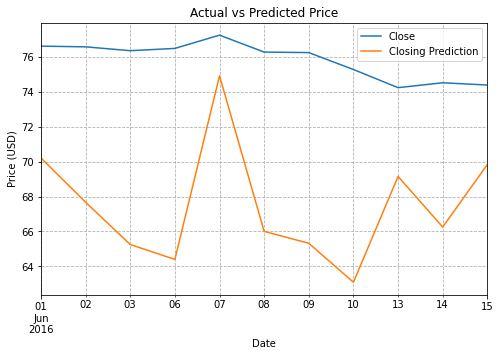

In [9]:
split = math.ceil(len(stock_sentiment) * 0.8)

train = stock_sentiment[:split]
test = stock_sentiment[split:]

predictors = ["Percent Positive", "Percent Negative", "Volume", "high_low_pct", "close_open_pct"]

scaler = MinMaxScaler()
scaler.fit(train[predictors])
X_train_scaled = scaler.transform(train[predictors])
X_test_scaled = scaler.transform(test[predictors])

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb_model.fit(X_train_scaled, train["Close"].values)
closing_pred = xgb_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Closing Prediction")
comparison = pd.concat([test["Close"], closing_pred], axis=1)

comparison.plot(figsize=(8,5),
                title="Actual vs Predicted Price",
                ylabel="Price (USD)")
plt.grid(which="both", linestyle="--")
plt.show()

In [10]:
def regression_metrics(y_true, yhat):
    '''return R^2, MSE, MAE, and RMSE metrics'''

    print(f'R^2: {metrics.r2_score(y_true, yhat)}')
    print(f'Mean Squared Error: {metrics.mean_squared_error(y_true, yhat)}')
    print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_true, yhat)}')
    print(f'Root MSE: {metrics.mean_squared_error(y_true, yhat, squared=False)}')
    print(f'% MAE: {metrics.mean_absolute_percentage_error(y_true, yhat)}')

regression_metrics(test["Close"], closing_pred)

R^2: -80.02724190620344
Mean Squared Error: 80.41723340506643
Mean Absolute Error: 8.379764345836293
Root MSE: 8.967565634277031
% MAE: 0.11042717722346373


### SVR

In [11]:
from sklearn.svm import SVR

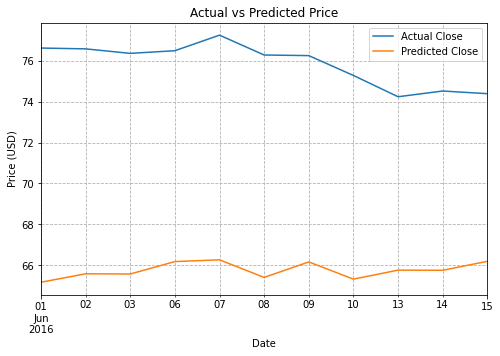

In [12]:
svr_model = SVR(kernel="rbf")
svr_model.fit(X_train_scaled, train["Close"].values)
closing_pred = svr_model.predict(X_test_scaled)

closing_pred = pd.Series(closing_pred, index=test.index, name="Predicted Close")

comparison = pd.concat([test["Close"], closing_pred], axis=1,)
comparison.rename({"Close": "Actual Close"}, axis=1, inplace=True)

comparison.plot(figsize=(8,5),
                title="Actual vs Predicted Price",
                ylabel="Price (USD)")
plt.grid(which="both", linestyle="--")
plt.show()

In [13]:
regression_metrics(test["Close"], closing_pred)

R^2: -102.46333841998592
Mean Squared Error: 102.68442117552054
Mean Absolute Error: 10.076772886475517
Root MSE: 10.133332185195576
% MAE: 0.13271358910130004
